In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection_lgbm = json.load(f)

with open('../feat_selection/select_optuna_catb.json', 'r') as f:
    feature_selection_catb = json.load(f)

# Extract the selected features
numerical_cols = feature_selection_lgbm.get('numerical', [])
categorical_cols = feature_selection_lgbm.get('categorical', [])

# numerical_cols = list(set(feature_selection_lgbm.get('numerical', []) + feature_selection_catb.get('numerical', [])))
# categorical_cols = list(set(feature_selection_lgbm.get('categorical', []) + feature_selection_catb.get('categorical', [])))

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))
print("Text features:", len(text_cols))

Numerical features: 296
Categorical features: 5
Text features: 0


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 368
Categorical Columns: 5


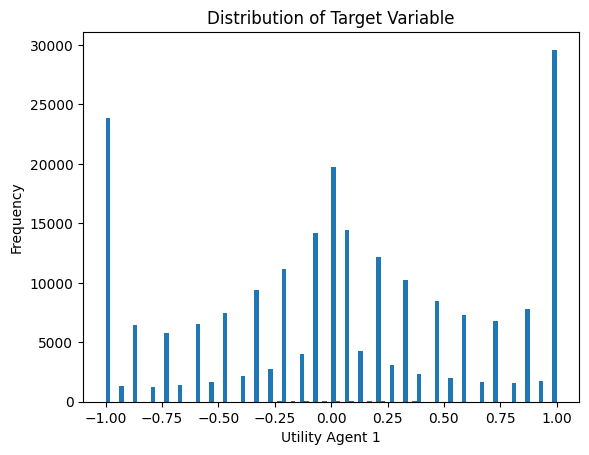

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [7]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [8]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.02,
        'depth': 10,
        'iterations': 10_000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        # testing:
        # 'bootstrap_type': 'Bayesian',
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1
0:	learn: 0.6320641	test: 0.5535351	best: 0.5535351 (0)	total: 145ms	remaining: 24m 8s
50:	learn: 0.4941643	test: 0.5127861	best: 0.5127861 (50)	total: 3.94s	remaining: 12m 48s
100:	learn: 0.4456642	test: 0.4936490	best: 0.4936490 (100)	total: 7.93s	remaining: 12m 57s
150:	learn: 0.4186251	test: 0.4788769	best: 0.4788769 (150)	total: 12.1s	remaining: 13m 7s
200:	learn: 0.4007817	test: 0.4696071	best: 0.4696071 (200)	total: 16.3s	remaining: 13m 14s
250:	learn: 0.3876876	test: 0.4639589	best: 0.4639589 (250)	total: 21s	remaining: 13m 37s
300:	learn: 0.3777994	test: 0.4593142	best: 0.4593142 (300)	total: 25.5s	remaining: 13m 42s
350:	learn: 0.3697001	test: 0.4556888	best: 0.4556888 (350)	total: 30s	remaining: 13m 45s
400:	learn: 0.3623024	test: 0.4515173	best: 0.4515173 (400)	total: 34.6s	remaining: 13m 48s
450:	learn: 0.3555371	test: 0.4479520	best: 0.4479520 (450)	total: 39.3s	remaining: 13m 51s
500:	learn: 0.3501729	test: 0.4456678	best: 0.4456678 (500)	total: 43.9s	remaining: 1

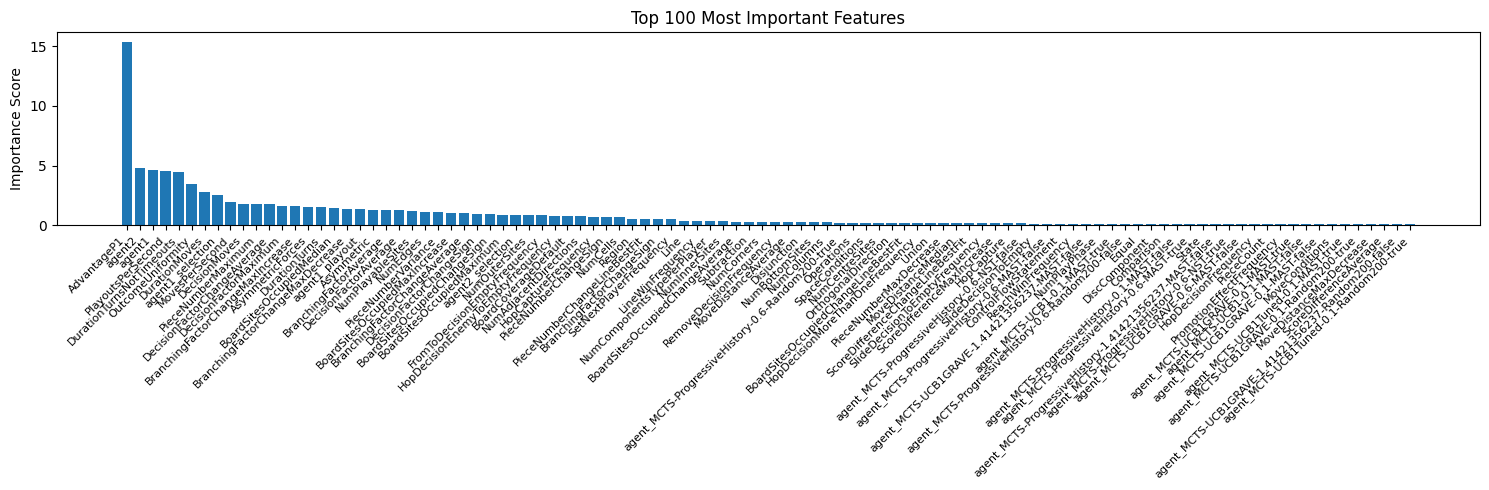

Fold 1 - RMSE: 0.41725001046573185
Fold 2
0:	learn: 0.6241940	test: 0.5890200	best: 0.5890200 (0)	total: 75.4ms	remaining: 12m 34s
50:	learn: 0.4949913	test: 0.5270793	best: 0.5270793 (50)	total: 3.75s	remaining: 12m 11s
100:	learn: 0.4490081	test: 0.5023867	best: 0.5023867 (100)	total: 7.61s	remaining: 12m 25s
150:	learn: 0.4234671	test: 0.4876199	best: 0.4876199 (150)	total: 11.6s	remaining: 12m 33s
200:	learn: 0.4058533	test: 0.4780143	best: 0.4780143 (200)	total: 15.7s	remaining: 12m 44s
250:	learn: 0.3939159	test: 0.4725364	best: 0.4725364 (250)	total: 20s	remaining: 12m 56s
300:	learn: 0.3841080	test: 0.4684081	best: 0.4683950 (299)	total: 24.3s	remaining: 13m 3s
350:	learn: 0.3758006	test: 0.4649889	best: 0.4649889 (350)	total: 28.6s	remaining: 13m 4s
400:	learn: 0.3690106	test: 0.4619016	best: 0.4619016 (400)	total: 32.8s	remaining: 13m 4s
450:	learn: 0.3614562	test: 0.4585554	best: 0.4585554 (450)	total: 36.8s	remaining: 12m 59s
500:	learn: 0.3547641	test: 0.4558467	best: 0.45

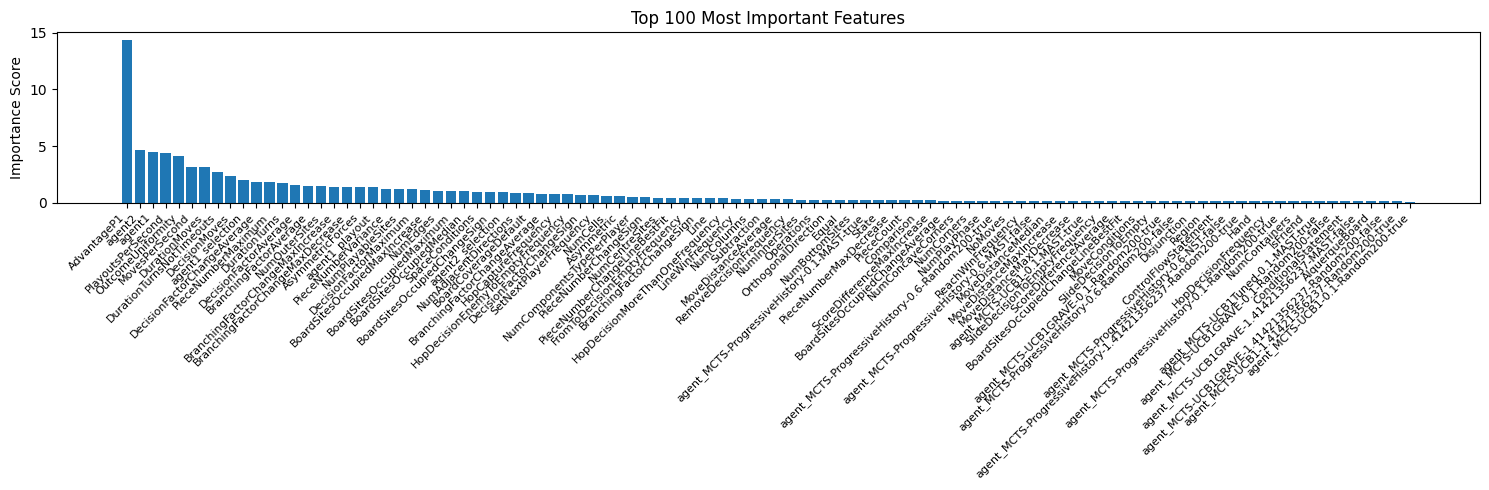

Fold 2 - RMSE: 0.4302510877522118
Fold 3
0:	learn: 0.6210455	test: 0.6058324	best: 0.6058324 (0)	total: 73.9ms	remaining: 12m 18s
50:	learn: 0.4930329	test: 0.5297153	best: 0.5297153 (50)	total: 3.88s	remaining: 12m 37s
100:	learn: 0.4489284	test: 0.4966029	best: 0.4966029 (100)	total: 7.82s	remaining: 12m 46s
150:	learn: 0.4230450	test: 0.4818547	best: 0.4818547 (150)	total: 11.9s	remaining: 12m 54s
200:	learn: 0.4068245	test: 0.4720968	best: 0.4720968 (200)	total: 16.1s	remaining: 13m 6s
250:	learn: 0.3944168	test: 0.4663348	best: 0.4663348 (250)	total: 20.3s	remaining: 13m 9s
300:	learn: 0.3846891	test: 0.4617131	best: 0.4617131 (300)	total: 24.6s	remaining: 13m 13s
350:	learn: 0.3764093	test: 0.4576484	best: 0.4576484 (350)	total: 28.9s	remaining: 13m 14s
400:	learn: 0.3686266	test: 0.4543387	best: 0.4543387 (400)	total: 33.1s	remaining: 13m 12s
450:	learn: 0.3620805	test: 0.4510292	best: 0.4510292 (450)	total: 37.4s	remaining: 13m 12s
500:	learn: 0.3563523	test: 0.4482391	best: 0.

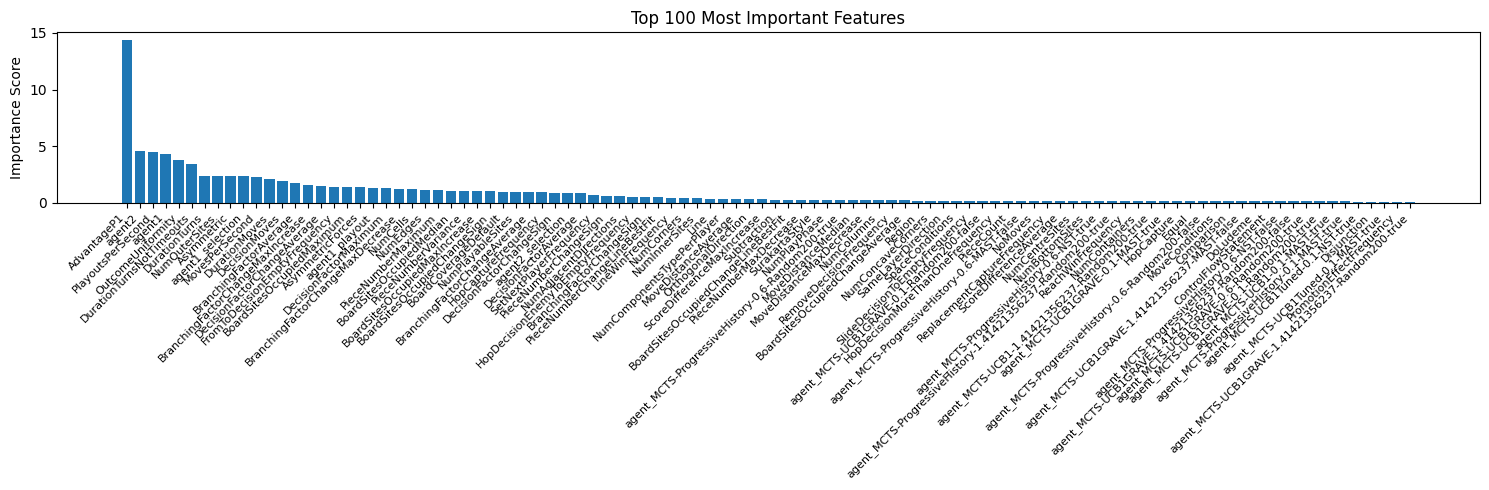

Fold 3 - RMSE: 0.4190606575518477
Fold 4
0:	learn: 0.6230795	test: 0.5970144	best: 0.5970144 (0)	total: 76ms	remaining: 12m 40s
50:	learn: 0.4879643	test: 0.5371600	best: 0.5371600 (50)	total: 3.86s	remaining: 12m 32s
100:	learn: 0.4434083	test: 0.5158152	best: 0.5158152 (100)	total: 7.84s	remaining: 12m 48s
150:	learn: 0.4187797	test: 0.5028495	best: 0.5028495 (150)	total: 11.9s	remaining: 12m 58s
200:	learn: 0.4030202	test: 0.4924311	best: 0.4924311 (200)	total: 16.3s	remaining: 13m 14s
250:	learn: 0.3911788	test: 0.4851485	best: 0.4851485 (250)	total: 20.7s	remaining: 13m 22s
300:	learn: 0.3827687	test: 0.4808669	best: 0.4808669 (300)	total: 25.1s	remaining: 13m 30s
350:	learn: 0.3748222	test: 0.4762348	best: 0.4762348 (350)	total: 29.5s	remaining: 13m 31s
400:	learn: 0.3672706	test: 0.4717981	best: 0.4717981 (400)	total: 33.8s	remaining: 13m 29s
450:	learn: 0.3606344	test: 0.4681298	best: 0.4681298 (450)	total: 38s	remaining: 13m 24s
500:	learn: 0.3546948	test: 0.4652626	best: 0.46

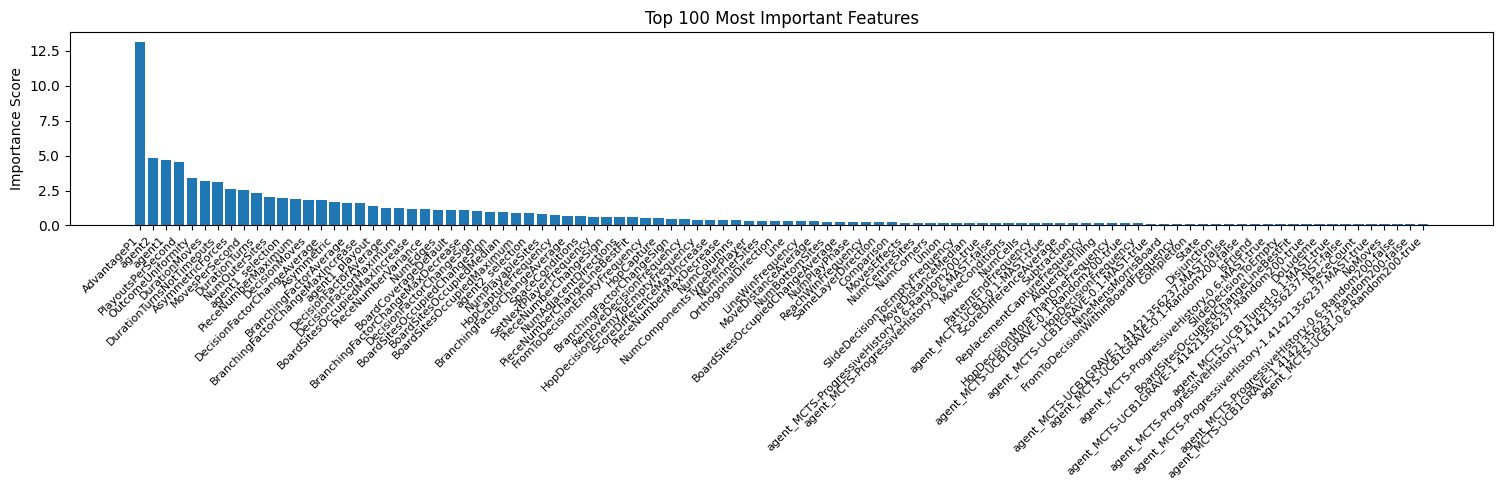

Fold 4 - RMSE: 0.43631806153404457
Fold 5
0:	learn: 0.6347297	test: 0.5480537	best: 0.5480537 (0)	total: 61.6ms	remaining: 10m 16s
50:	learn: 0.4981412	test: 0.5059310	best: 0.5059310 (50)	total: 3.8s	remaining: 12m 22s
100:	learn: 0.4524376	test: 0.4842279	best: 0.4842279 (100)	total: 7.65s	remaining: 12m 29s
150:	learn: 0.4271172	test: 0.4665596	best: 0.4665596 (150)	total: 11.6s	remaining: 12m 36s
200:	learn: 0.4114702	test: 0.4551519	best: 0.4551519 (200)	total: 15.9s	remaining: 12m 52s
250:	learn: 0.3992710	test: 0.4481522	best: 0.4481522 (250)	total: 20.1s	remaining: 13m 1s
300:	learn: 0.3895781	test: 0.4422983	best: 0.4422983 (300)	total: 24.5s	remaining: 13m 8s
350:	learn: 0.3818179	test: 0.4383779	best: 0.4383779 (350)	total: 28.8s	remaining: 13m 12s
400:	learn: 0.3749139	test: 0.4349684	best: 0.4349684 (400)	total: 33s	remaining: 13m 10s
450:	learn: 0.3676467	test: 0.4306805	best: 0.4306805 (450)	total: 37.2s	remaining: 13m 7s
500:	learn: 0.3622368	test: 0.4281171	best: 0.428

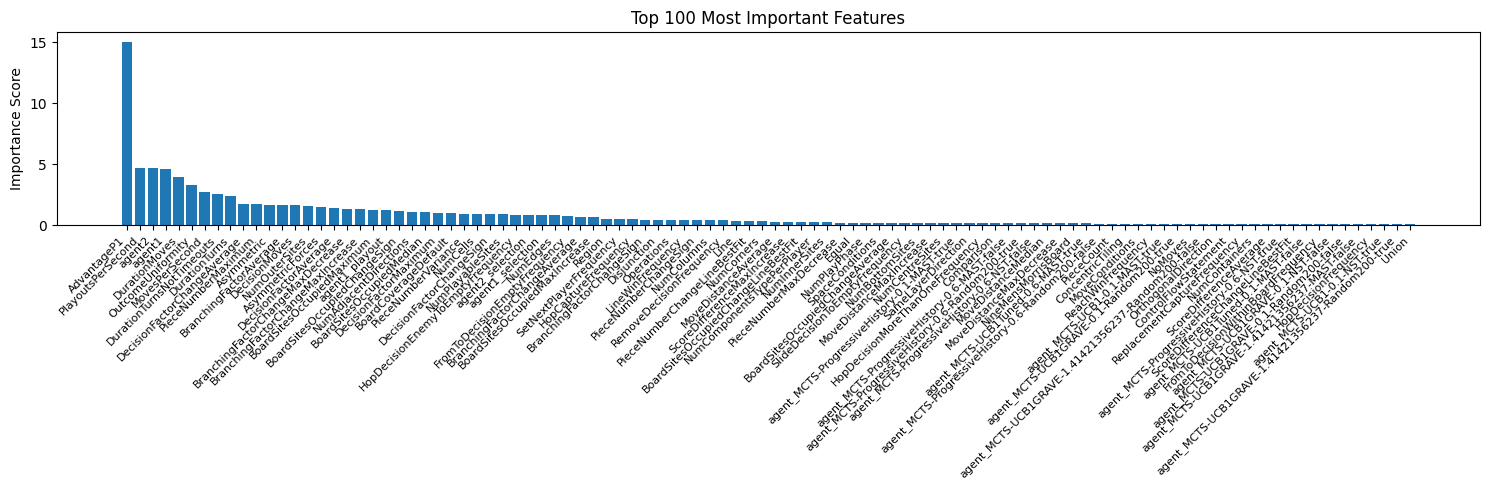

Fold 5 - RMSE: 0.3972456189325651
List of oof scores: [0.41725001046573185, 0.4302510877522118, 0.4190606575518477, 0.43631806153404457, 0.3972456189325651]
Average oof score: 0.4200250872472802


In [9]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_csv(path_results / 'oof_catboost_cv1.csv', index=False)
# save feature importance
importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

In [10]:
# # call the function
# trained_models3, oof3, oof_scores3 = train_models(
#     df_train, 
#     numerical_cols, 
#     categorical_cols, 
#     text_cols=text_cols,
#     split_list=split3,
# )
# # save oof predictions
# oof3.to_csv(path_results / 'oof_catboost_cv3.csv', index=False)

In [11]:
# trained_models = [*trained_models1, *trained_models2, *trained_models3]
trained_models = trained_models1

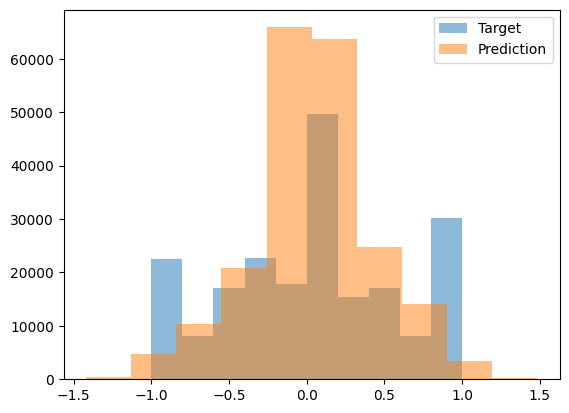

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols + text_cols],
        # data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

Id,utility_agent1
i64,f64
233234,0.11207
233235,-0.14541
233236,-0.043858


In [16]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [17]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***